In [18]:
import tensorflow as tf
tf.random.set_seed(42)

import numpy as np
import pandas as pd

from tensorflow import keras
from tensorflow.keras.models import load_model

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import plot_model

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams

In [19]:
def show_img_dataset(X, y=None, nrows = 4, ncols=4, firstimg=100, numimg=4):
    for i in range(numimg):
        sp = plt.subplot(nrows, ncols, i + 1)

        sp.axis('Off')
        plt.imshow(X[firstimg+i], cmap="Greys")
        if (y is not None):
            plt.title(y[firstimg+i])
    plt.show()

In [20]:
def show_pairs(X, y, image):
    sp = plt.subplot(1, 2, 1)
    plt.imshow(X[image][0])
    sp = plt.subplot(1, 2, 2)
    plt.imshow(X[image][1])
    plt.figtext(0.5, 0.01, str(y[image]), wrap=True, horizontalalignment='center', fontsize=12)
    plt.show()

In [21]:
train_df=pd.read_csv('train.csv')
test_df=pd.read_csv('test.csv')

X = train_df.drop('label', axis=1)
y_train = train_df['label']

X.shape, y_train.shape

((42000, 784), (42000,))

In [22]:
X_train = np.array(X).reshape((-1, 28, 28, 1))
X_test = np.array(test_df).reshape((-1, 28, 28, 1))
X.shape, X_test.shape

((42000, 784), (28000, 28, 28, 1))

In [23]:

X_train = X_train.astype('float32') / 255
X_text = X_test.astype('float32') / 255

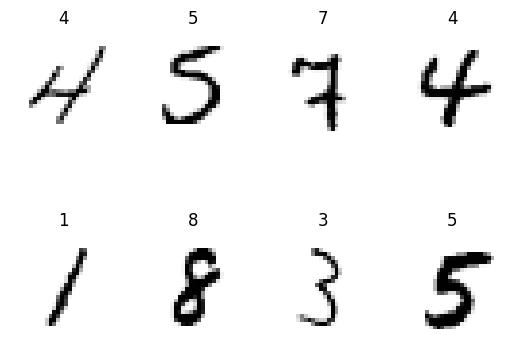

In [24]:
show_img_dataset(X_train, y = y_train, firstimg=700, nrows = 2, ncols=4, numimg=8)

In [25]:
def create_pairs(X, y, min_equals = 3000):
    pairs = []
    labels = []
    equal_items = 0

    index = [np.where(y == i)[0] for i in range(10)]

    for n_item in range(len(X)):
        if equal_items < min_equals:
            num_rnd = np.random.randint(len(index[y[n_item]]))
            num_item_pair = index[y[n_item]][num_rnd]

            equal_items += 1
        else:

            num_item_pair = np.random.randint(len(X))

        labels += [int(y[n_item] == y[num_item_pair])]
        pairs += [[X[n_item], X[num_item_pair]]]

    return np.array(pairs), np.array(labels).astype('float32')

In [26]:
LIMIT_VAL = 2000
X_train2 = []
y_train2 = []
X_val = X_train[:LIMIT_VAL]
y_val = y_train[:LIMIT_VAL].reset_index(drop=True)
X_train2 = X_train[LIMIT_VAL:]
y_train2 = y_train[LIMIT_VAL:].reset_index(drop=True)

In [27]:
training_pairs, training_labels = create_pairs(X_train2, y_train2, min_equals=15000)
val_pairs, val_labels = create_pairs(X_val, y_val, min_equals=800)

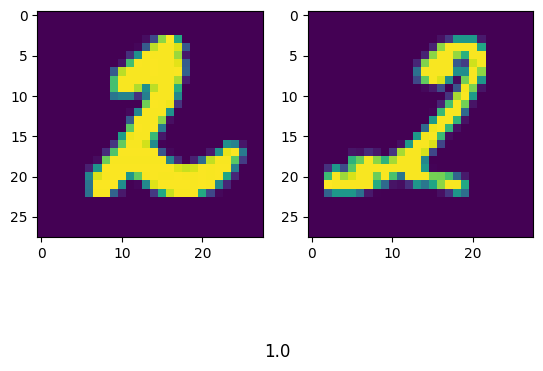

In [28]:
show_pairs(training_pairs, training_labels, 34004)

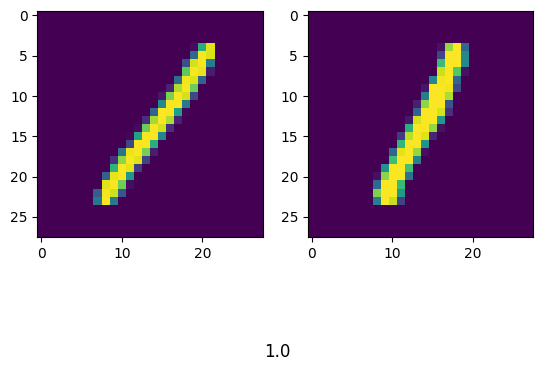

In [29]:
show_pairs(training_pairs, training_labels, 34)

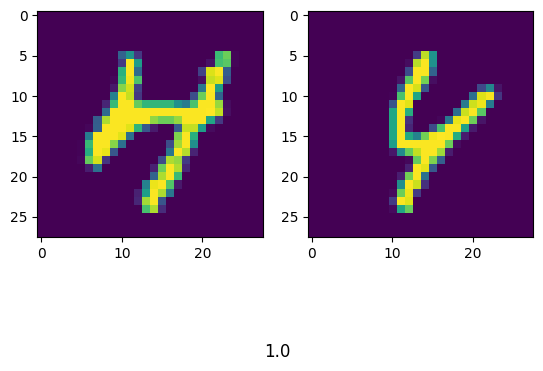

In [30]:
show_pairs(val_pairs, val_labels, 32)

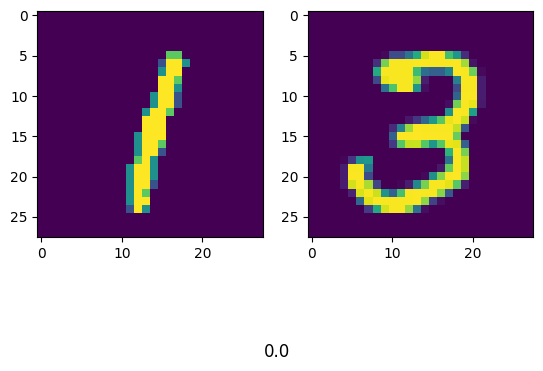

In [31]:
show_pairs(val_pairs, val_labels, 1500)

In [32]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [33]:
def contrastive_loss_with_margin(margin):
    def contrastive_loss(y_true, y_pred):
        square_pred = K.square(y_pred)
        margin_square = K.square(K.maximum(margin - y_pred, 0))
        return (y_true * square_pred + (1 - y_true) * margin_square)
    return contrastive_loss

In [34]:
def initialize_base_branch():
    input = Input(shape=(28,28,), name="base_input")
    x = Flatten(name="flatten_input")(input)
    x = Dense(128, activation='relu', name="first_base_dense")(x)
    x = Dropout(0.3, name="first_dropout")(x)
    x = Dense(128, activation='relu', name="second_base_dense")(x)
    x = Dropout(0.3, name="second_dropout")(x)
    x = Dense(128, activation='relu', name="third_base_dense")(x)
    return Model(inputs=input, outputs=x)

base_model = initialize_base_branch()

In [35]:
input_l = Input(shape=(28, 28,), name='left_input')
vect_output_l = base_model(input_l)
input_r = Input(shape=(28, 28,), name='right_input')
vect_output_r = base_model(input_r)
output = Lambda(euclidean_distance, name='output_layer',
                output_shape=eucl_dist_output_shape)([vect_output_l, vect_output_r])
model = Model([input_l, input_r], output)

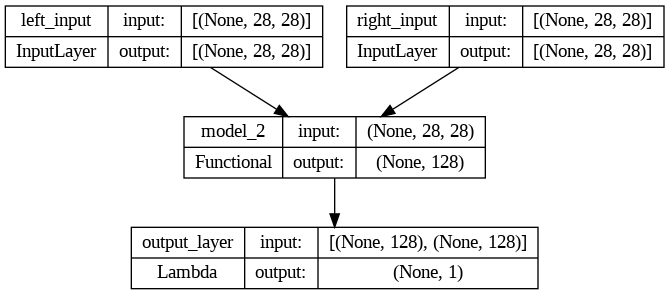

In [36]:
from tensorflow.keras.utils import plot_model
tf.keras.utils.plot_model(model, to_file='siamese_model.png', show_shapes=True)

In [49]:
rms = RMSprop()
model.compile(loss=contrastive_loss_with_margin(margin=1),
              optimizer=rms,metrics=['accuracy'])
history = model.fit(
    [training_pairs[:,0], training_pairs[:,1]],
    training_labels, epochs=20,
    batch_size=128,
    validation_data = ([val_pairs[:, 0], val_pairs[:, 1]], val_labels))

Epoch 1/20
313/313 [==============================] - 4s 8ms/step - loss: 0.0274 - accuracy: 0.0280 - val_loss: 0.0352 - val_accuracy: 0.0380
Epoch 2/20
313/313 [==============================] - 4s 12ms/step - loss: 0.0255 - accuracy: 0.0262 - val_loss: 0.0357 - val_accuracy: 0.0390
Epoch 3/20
313/313 [==============================] - 3s 10ms/step - loss: 0.0258 - accuracy: 0.0266 - val_loss: 0.0379 - val_accuracy: 0.0400
Epoch 4/20
313/313 [==============================] - 4s 12ms/step - loss: 0.0258 - accuracy: 0.0259 - val_loss: 0.0351 - val_accuracy: 0.0385
Epoch 5/20
313/313 [==============================] - 3s 9ms/step - loss: 0.0237 - accuracy: 0.0234 - val_loss: 0.0320 - val_accuracy: 0.0335
Epoch 6/20
313/313 [==============================] - 2s 8ms/step - loss: 0.0235 - accuracy: 0.0237 - val_loss: 0.0376 - val_accuracy: 0.0380
Epoch 7/20
313/313 [==============================] - 2s 8ms/step - loss: 0.0238 - accuracy: 0.0237 - val_loss: 0.0371 - val_accuracy: 0.0365
Epo

In [50]:
def compute_accuracy(y_true, y_pred):
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)

In [51]:
y_pred_train = model.predict([training_pairs[:,0], training_pairs[:,1]])
train_accuracy = compute_accuracy(training_labels, y_pred_train)

y_pred_val = model.predict([val_pairs[:,0], val_pairs[:,1]])
val_accuracy = compute_accuracy(val_labels, y_pred_val)

print("Train Accuracy = {} Val accuracy = {}".format(train_accuracy, val_accuracy))

63/63 [==============================] - 0s 2ms/step
Train Accuracy = 0.9912 Val accuracy = 0.9655


In [52]:
def visualize_images():
    plt.rc('image', cmap='gray_r')
    plt.rc('grid', linewidth=0)
    plt.rc('xtick', top=False, bottom=False, labelsize='large')
    plt.rc('ytick', left=False, right=False, labelsize='large')
    plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
    plt.rc('text', color='a8151a')
    plt.rc('figure', facecolor='F0F0F0')

In [53]:
def display_images(left, right, predictions, labels, title, n):
    plt.figure(figsize=(17,3))
    plt.title(title)
    plt.yticks([])
    plt.xticks([])
    plt.grid(None)
    left = np.reshape(left, [n, 28, 28])
    left = np.swapaxes(left, 0, 1)
    left = np.reshape(left, [28, 28*n])
    plt.imshow(left)
    plt.figure(figsize=(17,3))
    plt.yticks([])
    plt.xticks([28*x+14 for x in range(n)], predictions)
    for i,t in enumerate(plt.gca().xaxis.get_ticklabels()):
        if predictions[i] > 0.5: t.set_color('red')
    plt.grid(None)
    right = np.reshape(right, [n, 28, 28])
    right = np.swapaxes(right, 0, 1)
    right = np.reshape(right, [28, 28*n])
    plt.imshow(right)

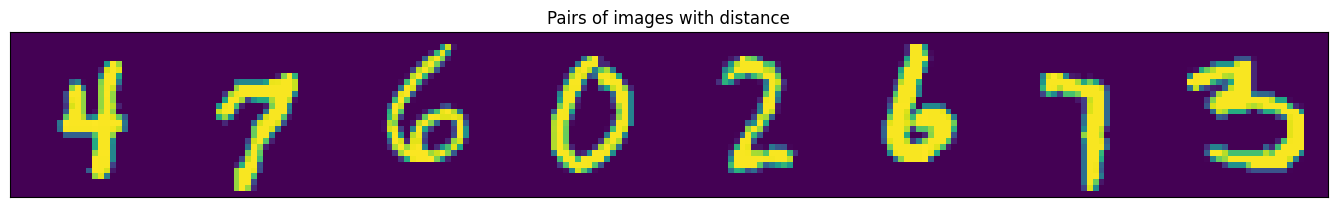

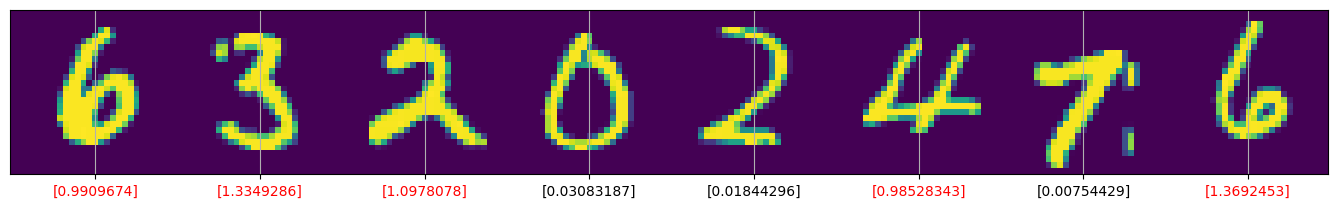

In [54]:
indexes = np.random.choice(len(y_pred_train), size=8)
display_images(training_pairs[:, 0][indexes],
               training_pairs[:, 1][indexes],
               y_pred_train[indexes],
               training_labels[indexes],
               "Pairs of images with distance", 8)

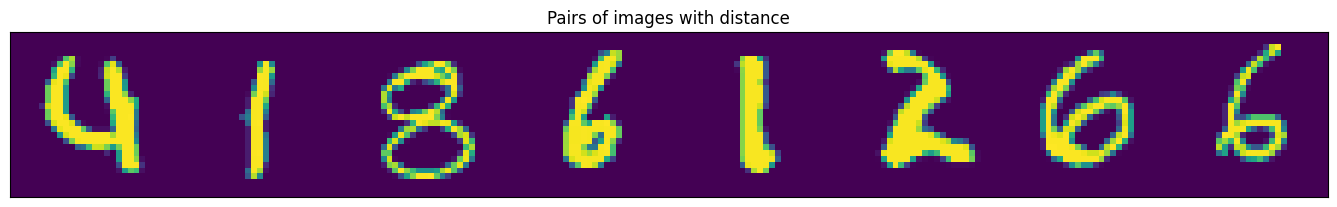

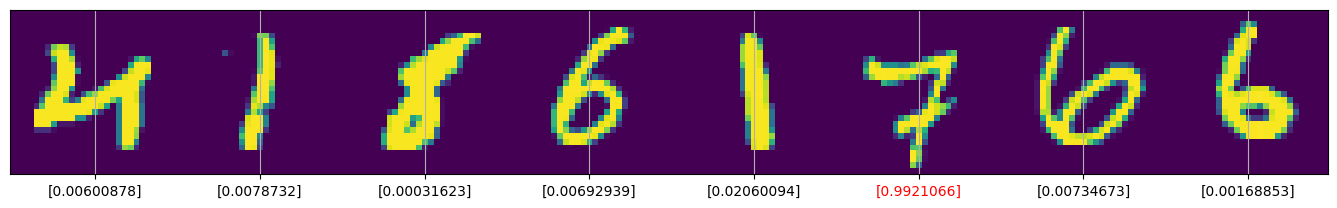

In [55]:
indexes = np.random.choice(len(y_pred_train), size=8)
display_images(training_pairs[:, 0][indexes],
               training_pairs[:, 1][indexes],
               y_pred_train[indexes],
               training_labels[indexes],
               "Pairs of images with distance", 8)

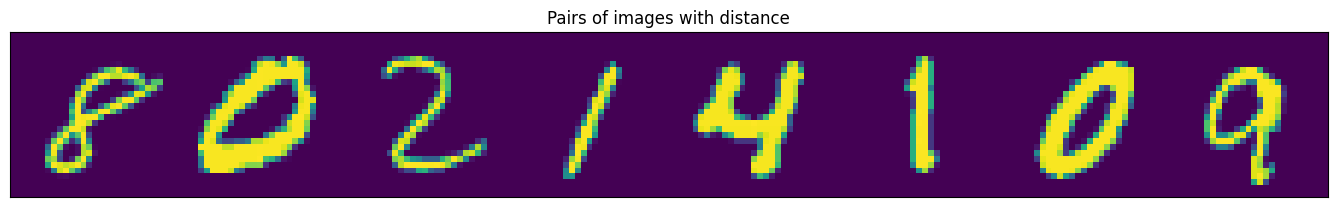

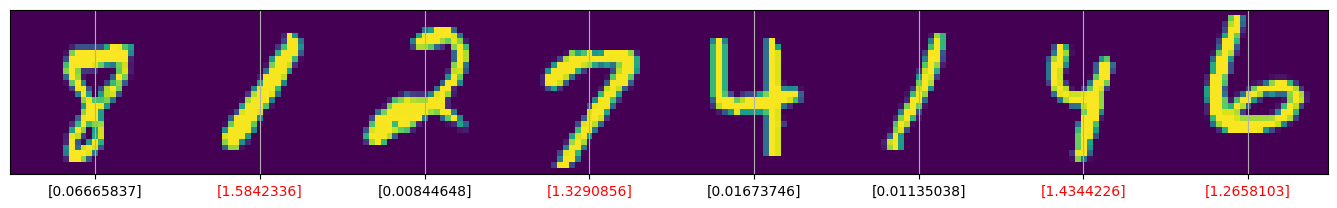

In [56]:
indexes = np.random.choice(len(y_pred_train), size=8)
display_images(training_pairs[:, 0][indexes],
               training_pairs[:, 1][indexes],
               y_pred_train[indexes],
               training_labels[indexes],
               "Pairs of images with distance", 8)

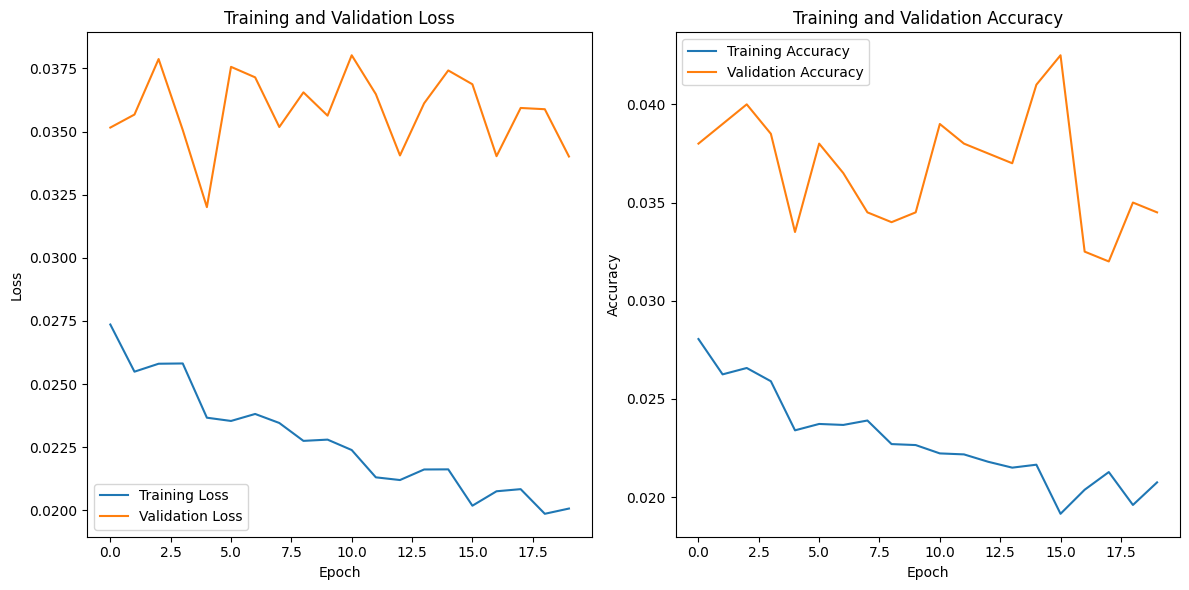

In [57]:
# Plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 6))

    # Plot Training & Validation Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Training & Validation Accuracy
    plt.subplot(1, 2, 2)
    if 'accuracy' in history.history:
        plt.plot(history.history['accuracy'], label='Training Accuracy')
    elif 'acc' in history.history:
        plt.plot(history.history['acc'], label='Training Accuracy')

    if 'val_accuracy' in history.history:
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    elif 'val_acc' in history.history:
        plt.plot(history.history['val_acc'], label='Validation Accuracy')

    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot the training history
plot_training_history(history)
